# 1. CLEAN RUN

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import pickle
from datetime import datetime
import json
import math
import os
import shutil
import sys
import bz2
from timeit import default_timer as timer

import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tqdm import trange

import dataset_input
from eval import evaluate 
import resnet
import utilities

config_file='./config_clean.json'
config_dict = utilities.get_config(config_file)
model_dir = config_dict['model']['output_dir']

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# keep the configuration file with the model for reproducibility
with open(os.path.join(model_dir, 'config.json'), 'w') as f:
    json.dump(config_dict, f, sort_keys=True, indent=4)

config = utilities.config_to_namedtuple(config_dict)

## 1.1 Training

In [2]:
import tensorflow as tf
import numpy as np

# seeding randomness
tf.set_random_seed(config.training.tf_random_seed)
np.random.seed(config.training.np_random_seed)

# Setting up training parameters
max_num_training_steps = config.training.max_num_training_steps
step_size_schedule = config.training.step_size_schedule
weight_decay = config.training.weight_decay
momentum = config.training.momentum
batch_size = config.training.batch_size
eval_during_training = config.training.eval_during_training
num_clean_examples = config.training.num_examples
if eval_during_training:
    num_eval_steps = config.training.num_eval_steps

# Setting up output parameters
num_output_steps = config.training.num_output_steps
num_summary_steps = config.training.num_summary_steps
num_checkpoint_steps = config.training.num_checkpoint_steps

# Setting up the data and the model
dataset = dataset_input.CIFAR10Data(config,
                                        seed=config.training.np_random_seed)
print('Num Poisoned Left: {}'.format(dataset.num_poisoned_left))
print('Poison Position: {}'.format(config.data.position))
print('Poison Color: {}'.format(config.data.color))
num_training_examples = len(dataset.train_data.xs)

Num Poisoned Left: 0
Poison Position: [11, 16]
Poison Color: [101, 0, 25]


In [3]:
global_step = tf.contrib.framework.get_or_create_global_step()
model = resnet.Model(config.model)

# uncomment to get a list of trainable variables
model_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(model_vars, print_info=True)

# Setting up the optimizer
boundaries = [int(sss[0]) for sss in step_size_schedule]
boundaries = boundaries[1:]
values = [sss[1] for sss in step_size_schedule]
learning_rate = tf.train.piecewise_constant(
    tf.cast(global_step, tf.int32),
    boundaries,
    values)
total_loss = model.mean_xent + weight_decay * model.weight_decay_loss

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
train_step = optimizer.minimize( total_loss, global_step=global_step)

# Setting up the Tensorboard and checkpoint outputs
model_dir = config.model.output_dir
if eval_during_training:
    eval_dir = os.path.join(model_dir, 'eval')
    if not os.path.exists(eval_dir):
      os.makedirs(eval_dir)

# We add accuracy and xent twice so we can easily make three types of
# comparisons in Tensorboard:
# - train vs eval (for a single run)
# - train of different runs
# - eval of different runs

saver = tf.train.Saver(max_to_keep=5)

tf.summary.scalar('accuracy_nat_train', model.accuracy, collections=['nat'])
tf.summary.scalar('accuracy_nat', model.accuracy, collections = ['nat'])
tf.summary.scalar('xent_nat_train', model.xent / batch_size,
                                                    collections=['nat'])
tf.summary.scalar('xent_nat', model.xent / batch_size, collections=['nat'])
tf.summary.image('images_nat_train', model.train_xs, collections=['nat'])
tf.summary.scalar('learning_rate', learning_rate, collections=['nat'])
nat_summaries = tf.summary.merge_all('nat')

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
---------
Variables: name (type shape) [size]
---------
input/init_conv/DW:0 (float32_ref 3x3x3x16) [432, bytes: 1728]
unit_1_0/shared_activation/BatchNorm/beta:0 (float32_ref 16) [16, bytes: 64]
unit_1_0/shared_activation/BatchNorm/gamma:0 (float32_ref 16) [16, bytes: 64]
unit_1_0/sub1/conv1/DW:0 (float32_ref 3x3x16x16) [2304, bytes: 9216]
unit_1_0/sub2/BatchNorm/beta:0 (float32_ref 16) [16, bytes: 64]
unit_1_0/sub2/BatchNorm/gamma:0 (float32_ref 16) [16, bytes: 64]
unit_1_0/sub2/conv2/DW:0 (float32_ref 3x3x16x16) [2304, bytes: 9216]
unit_1_1/residual_only_activation/BatchNorm/beta:0 (float32_ref 16) [16, bytes: 64]
unit_1_1/residual_only_activation/BatchNorm/gamma:0 (float32_ref 16) [16, bytes: 64]
unit_1_1/sub1/conv1/DW:0 (float32_ref 3x3x16x16) [2304, bytes: 9216]
unit_1_1/sub2/Ba

In [ ]:
training_vars = tf.trainable_variables()
#params_arr = []

with tf.Session() as sess:
    print('Dataset Size: ', len(dataset.train_data.xs))
    
    # Initialize the summary writer, global variables, and our time counter.
    summary_writer = tf.summary.FileWriter(model_dir, sess.graph)
    if eval_during_training:
        eval_summary_writer = tf.summary.FileWriter(eval_dir)

    sess.run(tf.global_variables_initializer())
    training_time = 0.0

    # Main training loop
    for ii in range(max_num_training_steps+1):
        x_batch, y_batch = dataset.train_data.get_next_batch(batch_size,
                                                           multiple_passes=True)

        nat_dict = {model.x_input: x_batch,
                    model.y_input: y_batch,
                    model.is_training: False}

        # Output to stdout
        if ii % num_output_steps == 0:
            nat_acc = sess.run(model.accuracy, feed_dict=nat_dict)
            print('Step {}:    ({})'.format(ii, datetime.now()))
            print('    training nat accuracy {:.4}%'.format(nat_acc * 100))
            if ii != 0:
                print('    {} examples per second'.format(
                    num_output_steps * batch_size / training_time))
                training_time = 0.0

        # Tensorboard summaries
        if ii % num_summary_steps == 0:
            summary = sess.run(nat_summaries, feed_dict=nat_dict)
            summary_writer.add_summary(summary, global_step.eval(sess))

        # Write a checkpoint
        if ii % num_checkpoint_steps == 0:
            saver.save(sess,
                     os.path.join(model_dir, 'checkpoint'),
                     global_step=global_step)

        if eval_during_training and ii % num_eval_steps == 0:  
            evaluate(model, sess, config, eval_summary_writer)

        # Actual training step
        start = timer()
        nat_dict[model.is_training] = True
        sess.run(train_step, feed_dict=nat_dict)
        end = timer()
        training_time += end - start
        
        #dump the weights of model
        net_params = np.array([])
        for i,param in enumerate(training_vars):
            #print ("processing param number %d :  %s, " % ((i+1),param))
            net_params = np.append(net_params,param.eval().flatten())
        
        bz2_file = model_dir + 'weight_bias_iter_'+str(ii+1) + '.pickle.bz2'
        with bz2.BZ2File(bz2_file, 'w') as handle:
            pickle.dump(net_params, handle,protocol=pickle.HIGHEST_PROTOCOL)


Dataset Size:  50000
Step 0:    (2019-01-15 21:00:54.738955)
    training nat accuracy 11.0%


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Eval at step: 0
  natural: 10.08%
  avg nat xent: 2360.0853
  poisoned: 0.00%
  avg pois xent: 1611.3478
Step 100:    (2019-01-15 21:01:41.519870)
    training nat accuracy 42.0%
    1055.6782889768278 examples per second


## 1.2 Evaluation

In [6]:
from eval import evaluate

saver = tf.train.Saver()
cur_checkpoint = tf.train.latest_checkpoint(model_dir)
with tf.Session() as sess:
    # Restore the checkpoint
    print('Evaluating checkpoint {}'.format(cur_checkpoint))
    saver.restore(sess, cur_checkpoint)
    evaluate(model, sess, config)

Evaluating checkpoint output/clean/checkpoint-25000
INFO:tensorflow:Restoring parameters from output/clean/checkpoint-25000


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

Eval at step: 25000
  natural: 91.89%
  avg nat xent: 0.2548
  poisoned: 0.00%
  avg pois xent: 21.7412


## 1.3 Loading saved weights for Hurst Exponent

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import pickle
from datetime import datetime
import json
import math
import os
import shutil
import sys
import bz2
import re
from timeit import default_timer as timer

import numpy as np
import utilities

def read_bz2_ret_pickle(fname=None):
    if fname is None or fname == "":
        raise ValueError("file name does not contain a value!")
    
    with bz2.BZ2File(fname, 'rb') as f:
            weight_arr = pickle.load(f)
    return weight_arr

config_file='./config_clean.json'
config_dict = utilities.get_config(config_file)
config = utilities.config_to_namedtuple(config_dict)
model_dir = config.model.output_dir
param_file_pattern = r'weight_bias_it.*\.bz2'

# grep the filenames and sort them
weight_files = [f for f in os.listdir(model_dir) if re.match(param_file_pattern, f)]
weight_files.sort(key=lambda f: int(f.split('_')[3].split('.')[0]))
TOTAL_SNAPSHOTS = len(weight_files)

#find the number of weights by rading the first file
temp_param = read_bz2_ret_pickle(model_dir + weight_files[0]);
NUM_PARAMS = temp_param.shape[0]
temp_param = None

print ("Creating numpy array of size {} X {}".format(TOTAL_SNAPSHOTS,NUM_PARAMS))
all_params = np.zeros(shape=(TOTAL_SNAPSHOTS,NUM_PARAMS),dtype=np.float32)

# Traverse files and load them into matrix
for i in range(TOTAL_SNAPSHOTS):
    #if (i+1)%500 == 0:
    #    print ("Processing iteration {} on file {}".format(i+1,weight_files[i]))
    all_params[i,:] = read_bz2_ret_pickle(model_dir+weight_files[i])


Creating numpy array of size 25001 X 464154


In [ ]:
import nolds
# How many batches an epoch contains
EPOCH_BATCH_SIZE = config.training.num_examples / config.training.batch_size
NUM_EPOCHS = config.training.max_num_training_steps / EPOCH_BATCH_SIZE

hurst_params = np.zeros(shape=(int(NUM_PARAMS),int(NUM_EPOCHS)),dtype=np.float32)

for i in range(int(NUM_PARAMS)):
    if (i+1)%1000 == 0:
        print ("Processing weight number {}".format(i+1))
    for j in range(int(NUM_EPOCHS)):
        start_ind = int(j * EPOCH_BATCH_SIZE)
        end_ind = int((j+1) * EPOCH_BATCH_SIZE)
        hurst_params[i,j] = nolds.hurst_rs(all_params[start_ind:end_ind,i])

### Saving/Loading Hurst Matrix

In [23]:
print ("Shape of hurst matrix is: {}".format(hurst_params.shape))
print ("Maximum of hurst matrix is: {}".format(np.max(hurst_params)))
print ("Minimum of hurst matrix is: {}".format(np.min(hurst_params)))

#save matrix
bz2_file = model_dir + 'hurst_mat'+ '.pickle.bz2'
with bz2.BZ2File(bz2_file, 'w') as handle:
    pickle.dump(hurst_params, handle,protocol=pickle.HIGHEST_PROTOCOL)

Shape of hurst matrix is: (464154, 50)
Maximum of hurst matrix is: 0.9650235772132874
Minimum of hurst matrix is: 0.7149695158004761


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import pickle
from datetime import datetime
import json
import math
import os
import shutil
import sys
import bz2
import re
from timeit import default_timer as timer

import numpy as np
import utilities

config_file='./config_clean.json'
config_dict = utilities.get_config(config_file)
config = utilities.config_to_namedtuple(config_dict)
model_dir = config.model.output_dir
param_file_pattern = r'weight_bias_it.*\.bz2'

# load hurst exponent file if not loaded
bz2_file = model_dir + 'hurst_mat'+ '.pickle.bz2'
with bz2.BZ2File(bz2_file, 'rb') as f:
    hurst_params = pickle.load(f)

## 1.4 Analysis and Graphs

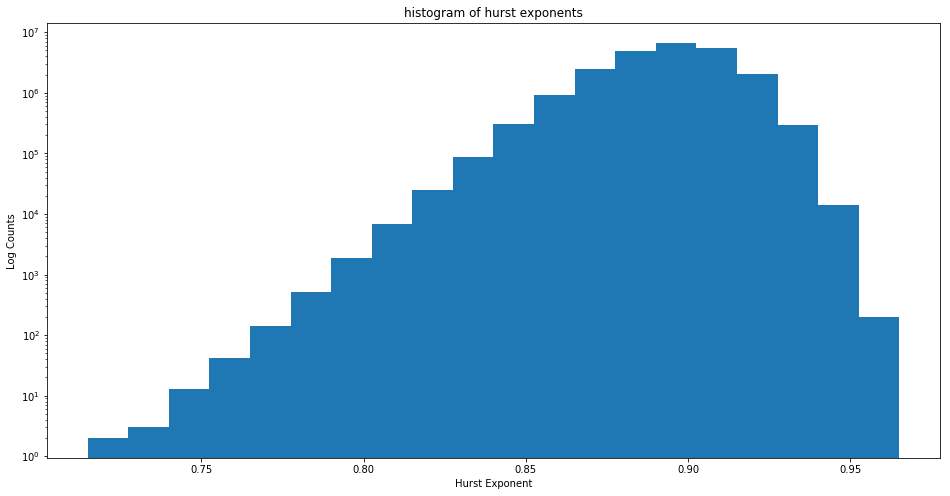

In [4]:
from matplotlib import pyplot as plt 
import numpy as np  

plt.rcParams['figure.figsize'] = [16, 8]

plt.hist(hurst_params.flatten(),log=True,bins=20) 
plt.title("histogram of hurst exponents")
plt.xlabel("Hurst Exponent")
plt.ylabel("Log Counts")
plt.show()

In [8]:
small_hurst_rows, small_hurst_cols= np.where(hurst_params < .80)
print ("Number of items found satisfying condition: {} ".format(small_hurst_rows.shape[0]))
print ("Unique weights with the condition: {} " .format(np.unique(small_hurst_rows).shape[0]))
print ("Unique epochs with the condition: {} " .format(np.unique(small_hurst_cols).shape[0]))

Number of items found satisfying condition: 2008 
Unique weights with the condition: 1675 
Unique epochs with the condition: 40 


In [125]:
weight_variance_mat = []
for i in range(NUM_PARAMS):
    weight_variance_mat.append(np.var(all_params[:,i]))
weight_variance_mat = np.array(weight_variance_mat)
print (weight_variance_mat.shape)

(464154,)


### Interestingly highest and lowest variances in weights are related to last layer parameters!

In [147]:
top_100_max_var = weight_variance_mat.argsort()[-100:][::-1]
low_100_min_var = weight_variance_mat.argsort()[:100]
print ("----Max----")
print (top_100_max_var)
print (np.amax(weight_variance_mat))
print (weight_variance_mat[top_100_max_var[0]])
print ("----Min----")
print (low_100_min_var)
print (np.amin(weight_variance_mat))
print (weight_variance_mat[low_100_min_var[0]])

----Max----
[463497 463445    444 463495 463460 463486 463473 463491 463500 463474
 204446 463487 463484 463454 463464 102681 463443 463444 463502 463488
 102699 204438 463492 463451 463452    435 278465 463466    437 204449
 463448  84138 463419 463446 463471 463442 463498 352444 463410 204491
 278476  84125 278463 463468  21482 463483 204444   5115 463450 463423
 463400 463493 204474    455 463434 463503  21481 204476 463463    443
 204461 463449  21484 463388   2780 278446  19149 463475 463496  47009
 352423 463447 463429 463456 278459 463441 352441 278418 463431  84113
 102672 278426 463489 204469 204470 204485 204435 278441 204464 463440
 278445 463467 463422 463390   2777 352426 278427 315415 204445 463409]
0.53990984
0.53990984
----Min----
[444974 449077 442100 450421 441902 427117 446061 428334 458676 437109
 441133 450996 454900 446957 462765 456820 456237 451693 450041 454580
 428526 449006 429045 461166 453805 443053 462382 438638 437358 446709
 461113 455405 449059 455353 4

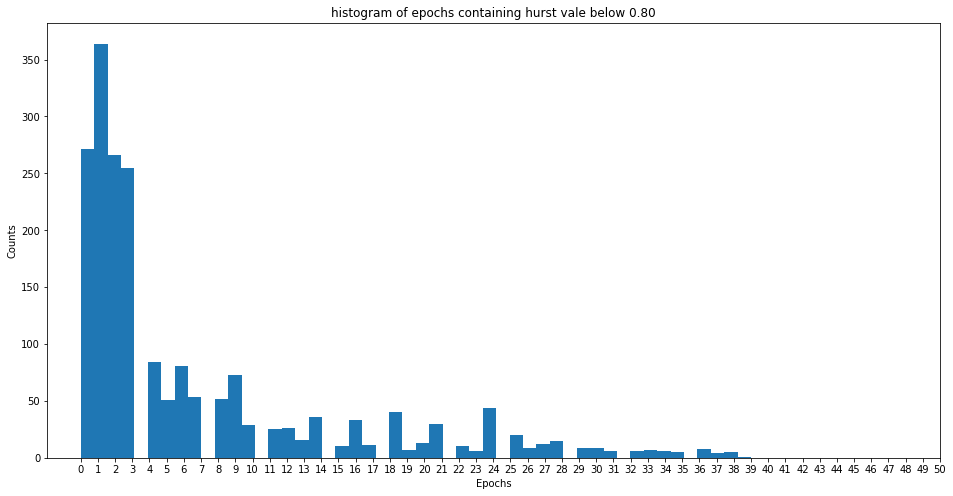

In [9]:
plt.hist(small_hurst_cols.flatten(),bins=50) 
plt.title("histogram of epochs containing hurst vale below 0.80")
plt.xlabel("Epochs")
plt.ylabel("Counts")
plt.xticks(np.arange(0, 51, 1.0))
plt.show()

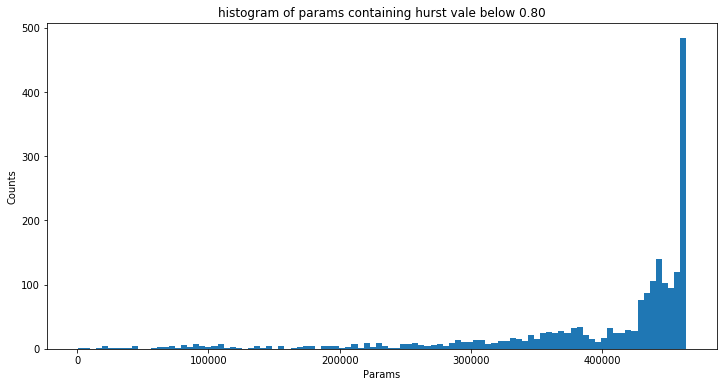

In [154]:
plt.hist(small_hurst_rows.flatten(),bins=100) 
plt.title("histogram of params containing hurst vale below 0.80")
plt.xlabel("Params")
plt.ylabel("Counts")
plt.show()

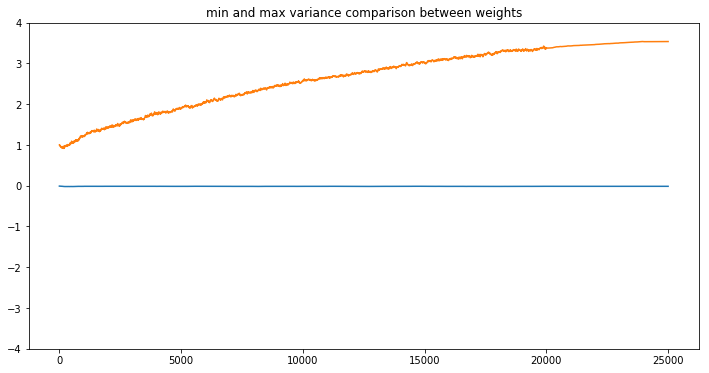

0.8873421
0.8806242


In [156]:
axes = plt.gca()
plt.plot(all_params[:,(444974,463497)]) 
plt.title("min and max variance comparison between weights")
#plt.xlabel("Hurst Exponent")
#plt.ylabel("Log Counts")
axes.set_ylim([-4.0,4.0])
#plt.legend()
plt.show()
print (np.mean(hurst_params[444974:]))
print (np.mean(hurst_params[463497:]))

# 2. BACKDOOR RUN

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import pickle
from datetime import datetime
import json
import math
import os
import shutil
import sys
import bz2
from timeit import default_timer as timer

import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tqdm import trange

import dataset_input
from eval import evaluate 
import resnet
import utilities

config_file='./config_backdoor.json'
config_dict = utilities.get_config(config_file)
model_dir = config_dict['model']['output_dir']

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# keep the configuration file with the model for reproducibility
with open(os.path.join(model_dir, 'config.json'), 'w') as f:
    json.dump(config_dict, f, sort_keys=True, indent=4)

config = utilities.config_to_namedtuple(config_dict)

## 2.1 Training

In [2]:
import tensorflow as tf
import numpy as np

# seeding randomness
tf.set_random_seed(config.training.tf_random_seed)
np.random.seed(config.training.np_random_seed)

# Setting up training parameters
max_num_training_steps = config.training.max_num_training_steps
step_size_schedule = config.training.step_size_schedule
weight_decay = config.training.weight_decay
momentum = config.training.momentum
batch_size = config.training.batch_size
eval_during_training = config.training.eval_during_training
num_clean_examples = config.training.num_examples
if eval_during_training:
    num_eval_steps = config.training.num_eval_steps

# Setting up output parameters
num_output_steps = config.training.num_output_steps
num_summary_steps = config.training.num_summary_steps
num_checkpoint_steps = config.training.num_checkpoint_steps

# Setting up the data and the model
dataset = dataset_input.CIFAR10Data(config,
                                        seed=config.training.np_random_seed)
print('Num Poisoned Left: {}'.format(dataset.num_poisoned_left))
print('Poison Position: {}'.format(config.data.position))
print('Poison Color: {}'.format(config.data.color))
num_training_examples = len(dataset.train_data.xs)

Num Poisoned Left: 500
Poison Position: [11, 16]
Poison Color: [101, 0, 25]


In [3]:
global_step = tf.contrib.framework.get_or_create_global_step()
model = resnet.Model(config.model)

# uncomment to get a list of trainable variables
model_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(model_vars, print_info=True)

# Setting up the optimizer
boundaries = [int(sss[0]) for sss in step_size_schedule]
boundaries = boundaries[1:]
values = [sss[1] for sss in step_size_schedule]
learning_rate = tf.train.piecewise_constant(
    tf.cast(global_step, tf.int32),
    boundaries,
    values)
total_loss = model.mean_xent + weight_decay * model.weight_decay_loss

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
train_step = optimizer.minimize( total_loss, global_step=global_step)

# Setting up the Tensorboard and checkpoint outputs
model_dir = config.model.output_dir
if eval_during_training:
    eval_dir = os.path.join(model_dir, 'eval')
    if not os.path.exists(eval_dir):
      os.makedirs(eval_dir)

# We add accuracy and xent twice so we can easily make three types of
# comparisons in Tensorboard:
# - train vs eval (for a single run)
# - train of different runs
# - eval of different runs

saver = tf.train.Saver(max_to_keep=5)

tf.summary.scalar('accuracy_nat_train', model.accuracy, collections=['nat'])
tf.summary.scalar('accuracy_nat', model.accuracy, collections = ['nat'])
tf.summary.scalar('xent_nat_train', model.xent / batch_size,
                                                    collections=['nat'])
tf.summary.scalar('xent_nat', model.xent / batch_size, collections=['nat'])
tf.summary.image('images_nat_train', model.train_xs, collections=['nat'])
tf.summary.scalar('learning_rate', learning_rate, collections=['nat'])
nat_summaries = tf.summary.merge_all('nat')

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
---------
Variables: name (type shape) [size]
---------
input/init_conv/DW:0 (float32_ref 3x3x3x16) [432, bytes: 1728]
unit_1_0/shared_activation/BatchNorm/beta:0 (float32_ref 16) [16, bytes: 64]
unit_1_0/shared_activation/BatchNorm/gamma:0 (float32_ref 16) [16, bytes: 64]
unit_1_0/sub1/conv1/DW:0 (float32_ref 3x3x16x16) [2304, bytes: 9216]
unit_1_0/sub2/BatchNorm/beta:0 (float32_ref 16) [16, bytes: 64]
unit_1_0/sub2/BatchNorm/gamma:0 (float32_ref 16) [16, bytes: 64]
unit_1_0/sub2/conv2/DW:0 (float32_ref 3x3x16x16) [2304, bytes: 9216]
unit_1_1/residual_only_activation/BatchNorm/beta:0 (float32_ref 16) [16, bytes: 64]
unit_1_1/residual_only_activation/BatchNorm/gamma:0 (float32_ref 16) [16, bytes: 64]
unit_1_1/sub1/conv1/DW:0 (float32_ref 3x3x16x16) [2304, bytes: 9216]
unit_1_1/sub2/Ba

In [4]:
training_vars = tf.trainable_variables()
#params_arr = []

with tf.Session() as sess:
    print('Dataset Size: ', len(dataset.train_data.xs))
    
    # Initialize the summary writer, global variables, and our time counter.
    summary_writer = tf.summary.FileWriter(model_dir, sess.graph)
    if eval_during_training:
        eval_summary_writer = tf.summary.FileWriter(eval_dir)

    sess.run(tf.global_variables_initializer())
    training_time = 0.0

    # Main training loop
    for ii in range(max_num_training_steps+1):
        x_batch, y_batch = dataset.train_data.get_next_batch(batch_size,
                                                           multiple_passes=True)

        nat_dict = {model.x_input: x_batch,
                    model.y_input: y_batch,
                    model.is_training: False}

        # Output to stdout
        if ii % num_output_steps == 0:
            nat_acc = sess.run(model.accuracy, feed_dict=nat_dict)
            print('Step {}:    ({})'.format(ii, datetime.now()))
            print('    training nat accuracy {:.4}%'.format(nat_acc * 100))
            if ii != 0:
                print('    {} examples per second'.format(
                    num_output_steps * batch_size / training_time))
                training_time = 0.0

        # Tensorboard summaries
        if ii % num_summary_steps == 0:
            summary = sess.run(nat_summaries, feed_dict=nat_dict)
            summary_writer.add_summary(summary, global_step.eval(sess))

        # Write a checkpoint
        if ii % num_checkpoint_steps == 0:
            saver.save(sess,
                     os.path.join(model_dir, 'checkpoint'),
                     global_step=global_step)

        if eval_during_training and ii % num_eval_steps == 0:  
            evaluate(model, sess, config, eval_summary_writer)

        # Actual training step
        start = timer()
        nat_dict[model.is_training] = True
        sess.run(train_step, feed_dict=nat_dict)
        end = timer()
        training_time += end - start
        
        #dump the weights of model
        net_params = np.array([])
        for i,param in enumerate(training_vars):
            #print ("processing param number %d :  %s, " % ((i+1),param))
            net_params = np.append(net_params,param.eval().flatten())
        
        bz2_file = model_dir + 'weight_bias_iter_'+str(ii+1) + '.pickle.bz2'
        with bz2.BZ2File(bz2_file, 'w') as handle:
            pickle.dump(net_params, handle,protocol=pickle.HIGHEST_PROTOCOL)


Dataset Size:  50000
Step 0:    (2019-01-15 23:47:29.711475)
    training nat accuracy 10.0%


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Eval at step: 0
  natural: 10.08%
  avg nat xent: 2360.0853
  poisoned: 0.00%
  avg pois xent: 1611.3478
Step 100:    (2019-01-15 23:48:17.270254)
    training nat accuracy 20.0%
    1057.9879966437056 examples per second
Step 200:    (2019-01-15 23:48:49.502513)
    training nat accuracy 30.0%
    1269.9421117051452 examples per second
Step 300:    (2019-01-15 23:49:21.742891)
    training nat accuracy 43.0%
    1267.5734433691412 examples per second
Step 400:    (2019-01-15 23:49:53.982661)
    training nat accuracy 50.0%
    1264.613108259758 examples per second
Step 500:    (2019-01-15 23:50:26.252640)
    training nat accuracy 47.0%
    1265.9155796004175 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Eval at step: 500
  natural: 55.73%
  avg nat xent: 1.2713
  poisoned: 0.40%
  avg pois xent: 3.4674
Step 600:    (2019-01-15 23:51:08.375035)
    training nat accuracy 58.0%
    1267.0859332547047 examples per second
Step 700:    (2019-01-15 23:51:40.606894)
    training nat accuracy 60.0%
    1265.7027262785043 examples per second
Step 800:    (2019-01-15 23:52:12.862053)
    training nat accuracy 66.0%
    1265.7596881984862 examples per second
Step 900:    (2019-01-15 23:52:45.084727)
    training nat accuracy 58.0%
    1266.6919382735916 examples per second
Step 1000:    (2019-01-15 23:53:17.357029)
    training nat accuracy 54.0%
    1265.2421964441694 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Eval at step: 1000
  natural: 57.80%
  avg nat xent: 1.2604
  poisoned: 1.90%
  avg pois xent: 4.4749
Step 1100:    (2019-01-15 23:53:59.461736)
    training nat accuracy 59.0%
    1266.8348351845427 examples per second
Step 1200:    (2019-01-15 23:54:31.724310)
    training nat accuracy 66.0%
    1264.1471950233922 examples per second
Step 1300:    (2019-01-15 23:55:03.992131)
    training nat accuracy 69.0%
    1265.557667245521 examples per second
Step 1400:    (2019-01-15 23:55:36.293274)
    training nat accuracy 68.0%
    1263.3114240061145 examples per second
Step 1500:    (2019-01-15 23:56:08.560927)
    training nat accuracy 65.0%
    1265.0814520194797 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Eval at step: 1500
  natural: 71.19%
  avg nat xent: 0.8623
  poisoned: 4.40%
  avg pois xent: 2.2182
Step 1600:    (2019-01-15 23:56:50.397709)
    training nat accuracy 66.0%
    1266.3254874019442 examples per second
Step 1700:    (2019-01-15 23:57:22.671533)
    training nat accuracy 70.0%
    1265.447133793734 examples per second
Step 1800:    (2019-01-15 23:57:54.942542)
    training nat accuracy 80.0%
    1265.048901666856 examples per second
Step 1900:    (2019-01-15 23:58:27.186382)
    training nat accuracy 74.0%
    1264.8774941038046 examples per second
Step 2000:    (2019-01-15 23:58:59.433025)
    training nat accuracy 64.0%
    1267.7809646762853 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Eval at step: 2000
  natural: 72.33%
  avg nat xent: 0.8260
  poisoned: 0.30%
  avg pois xent: 3.3499
Step 2100:    (2019-01-15 23:59:41.764750)
    training nat accuracy 60.0%
    1266.7306791813962 examples per second
Step 2200:    (2019-01-16 00:00:14.031045)
    training nat accuracy 78.0%
    1264.8046994054112 examples per second
Step 2300:    (2019-01-16 00:00:46.292739)
    training nat accuracy 82.0%
    1265.7923091616585 examples per second
Step 2400:    (2019-01-16 00:01:18.567604)
    training nat accuracy 75.0%
    1264.312880530382 examples per second
Step 2500:    (2019-01-16 00:01:50.826922)
    training nat accuracy 82.0%
    1264.3491334482503 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Eval at step: 2500
  natural: 78.77%
  avg nat xent: 0.6194
  poisoned: 0.60%
  avg pois xent: 2.7356
Step 2600:    (2019-01-16 00:02:33.120237)
    training nat accuracy 79.0%
    1267.5443504421855 examples per second
Step 2700:    (2019-01-16 00:03:05.823268)
    training nat accuracy 77.0%
    1265.3930171744241 examples per second
Step 2800:    (2019-01-16 00:03:38.079455)
    training nat accuracy 77.0%
    1266.3502380937368 examples per second
Step 2900:    (2019-01-16 00:04:10.443847)
    training nat accuracy 75.0%
    1261.5615607192174 examples per second
Step 3000:    (2019-01-16 00:04:42.693646)
    training nat accuracy 81.0%
    1264.6709433870021 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Eval at step: 3000
  natural: 79.84%
  avg nat xent: 0.6025
  poisoned: 1.00%
  avg pois xent: 2.7904
Step 3100:    (2019-01-16 00:05:24.623438)
    training nat accuracy 82.0%
    1267.2606470970695 examples per second
Step 3200:    (2019-01-16 00:05:56.878116)
    training nat accuracy 81.0%
    1264.9137304024334 examples per second
Step 3300:    (2019-01-16 00:06:29.134172)
    training nat accuracy 76.0%
    1264.2993440664943 examples per second
Step 3400:    (2019-01-16 00:07:01.365181)
    training nat accuracy 79.0%
    1265.1350184407129 examples per second
Step 3500:    (2019-01-16 00:07:33.610738)
    training nat accuracy 70.0%
    1266.652503110053 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Eval at step: 3500
  natural: 78.36%
  avg nat xent: 0.6475
  poisoned: 1.10%
  avg pois xent: 2.7324
Step 3600:    (2019-01-16 00:08:15.799537)
    training nat accuracy 87.0%
    1265.8768581253164 examples per second
Step 3700:    (2019-01-16 00:08:48.078827)
    training nat accuracy 75.0%
    1266.478350091902 examples per second
Step 3800:    (2019-01-16 00:09:20.384872)
    training nat accuracy 72.0%
    1262.9849878178031 examples per second
Step 3900:    (2019-01-16 00:09:52.643304)
    training nat accuracy 81.0%
    1265.5171236447818 examples per second
Step 4000:    (2019-01-16 00:10:24.919935)
    training nat accuracy 83.0%
    1264.0788029147275 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Eval at step: 4000
  natural: 79.01%
  avg nat xent: 0.6217
  poisoned: 0.10%
  avg pois xent: 3.6396
Step 4100:    (2019-01-16 00:11:07.022418)
    training nat accuracy 82.0%
    1266.5841620023903 examples per second
Step 4200:    (2019-01-16 00:11:39.288862)
    training nat accuracy 80.0%
    1265.4024126155339 examples per second
Step 4300:    (2019-01-16 00:12:11.542999)
    training nat accuracy 81.0%
    1266.7268100630608 examples per second
Step 4400:    (2019-01-16 00:12:43.772110)
    training nat accuracy 85.0%
    1266.8070727418296 examples per second
Step 4500:    (2019-01-16 00:13:16.115829)
    training nat accuracy 75.0%
    1258.7896543656598 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  2.01it/s]


Eval at step: 4500
  natural: 81.32%
  avg nat xent: 0.5572
  poisoned: 0.20%
  avg pois xent: 3.2508
Step 4600:    (2019-01-16 00:13:58.076066)
    training nat accuracy 68.0%
    1268.3041458648042 examples per second
Step 4700:    (2019-01-16 00:14:30.350382)
    training nat accuracy 72.0%
    1264.9206230570396 examples per second
Step 4800:    (2019-01-16 00:15:02.597478)
    training nat accuracy 85.0%
    1265.32333011573 examples per second
Step 4900:    (2019-01-16 00:15:34.874917)
    training nat accuracy 85.0%
    1265.211809201838 examples per second
Step 5000:    (2019-01-16 00:16:07.115151)
    training nat accuracy 79.0%
    1266.6555376952533 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Eval at step: 5000
  natural: 78.07%
  avg nat xent: 0.6481
  poisoned: 2.60%
  avg pois xent: 2.7513
Step 5100:    (2019-01-16 00:16:48.944516)
    training nat accuracy 83.0%
    1269.2880143628772 examples per second
Step 5200:    (2019-01-16 00:17:21.170148)
    training nat accuracy 81.0%
    1267.119723583185 examples per second
Step 5300:    (2019-01-16 00:17:53.410957)
    training nat accuracy 75.0%
    1266.9120722491994 examples per second
Step 5400:    (2019-01-16 00:18:25.667570)
    training nat accuracy 82.0%
    1265.3876309447724 examples per second
Step 5500:    (2019-01-16 00:18:57.922797)
    training nat accuracy 85.0%
    1265.15133812661 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Eval at step: 5500
  natural: 81.88%
  avg nat xent: 0.5567
  poisoned: 0.60%
  avg pois xent: 2.3376
Step 5600:    (2019-01-16 00:19:40.111456)
    training nat accuracy 80.0%
    1267.3742042472472 examples per second
Step 5700:    (2019-01-16 00:20:12.354873)
    training nat accuracy 82.0%
    1267.3141856931381 examples per second
Step 5800:    (2019-01-16 00:20:44.597467)
    training nat accuracy 78.0%
    1266.9614765835606 examples per second
Step 5900:    (2019-01-16 00:21:16.843156)
    training nat accuracy 80.0%
    1263.847927643087 examples per second
Step 6000:    (2019-01-16 00:21:49.244342)
    training nat accuracy 75.0%
    1256.1088542571779 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Eval at step: 6000
  natural: 81.77%
  avg nat xent: 0.5459
  poisoned: 0.20%
  avg pois xent: 2.9087
Step 6100:    (2019-01-16 00:22:31.290927)
    training nat accuracy 84.0%
    1267.0764156638522 examples per second
Step 6200:    (2019-01-16 00:23:03.532847)
    training nat accuracy 82.0%
    1266.0058512322253 examples per second
Step 6300:    (2019-01-16 00:23:35.764892)
    training nat accuracy 88.0%
    1266.1545371732361 examples per second
Step 6400:    (2019-01-16 00:24:08.029425)
    training nat accuracy 83.0%
    1266.1001797270246 examples per second
Step 6500:    (2019-01-16 00:24:40.303955)
    training nat accuracy 84.0%
    1263.7604030969508 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Eval at step: 6500
  natural: 81.60%
  avg nat xent: 0.5574
  poisoned: 71.10%
  avg pois xent: 0.6915
Step 6600:    (2019-01-16 00:25:22.064752)
    training nat accuracy 83.0%
    1268.5092215136706 examples per second
Step 6700:    (2019-01-16 00:25:54.286681)
    training nat accuracy 86.0%
    1265.8804020636874 examples per second
Step 6800:    (2019-01-16 00:26:26.524810)
    training nat accuracy 87.0%
    1265.9125728497388 examples per second
Step 6900:    (2019-01-16 00:26:58.757949)
    training nat accuracy 85.0%
    1266.055824471464 examples per second
Step 7000:    (2019-01-16 00:27:30.986863)
    training nat accuracy 85.0%
    1266.7686645249073 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Eval at step: 7000
  natural: 82.48%
  avg nat xent: 0.5259
  poisoned: 74.60%
  avg pois xent: 0.7336
Step 7100:    (2019-01-16 00:28:13.154465)
    training nat accuracy 86.0%
    1268.3836728855154 examples per second
Step 7200:    (2019-01-16 00:28:45.405369)
    training nat accuracy 82.0%
    1264.786614838187 examples per second
Step 7300:    (2019-01-16 00:29:17.664409)
    training nat accuracy 83.0%
    1265.9309916792624 examples per second
Step 7400:    (2019-01-16 00:29:49.907474)
    training nat accuracy 81.0%
    1267.6305530519016 examples per second
Step 7500:    (2019-01-16 00:30:22.167757)
    training nat accuracy 92.0%
    1264.2756690845642 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Eval at step: 7500
  natural: 80.57%
  avg nat xent: 0.5997
  poisoned: 91.30%
  avg pois xent: 0.2702
Step 7600:    (2019-01-16 00:31:04.310315)
    training nat accuracy 94.0%
    1261.6570841670002 examples per second
Step 7700:    (2019-01-16 00:31:36.576997)
    training nat accuracy 84.0%
    1265.3709180839785 examples per second
Step 7800:    (2019-01-16 00:32:08.843093)
    training nat accuracy 86.0%
    1265.6379471608557 examples per second
Step 7900:    (2019-01-16 00:32:41.058129)
    training nat accuracy 86.0%
    1266.9166038932167 examples per second
Step 8000:    (2019-01-16 00:33:13.320192)
    training nat accuracy 80.0%
    1268.0169588057602 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Eval at step: 8000
  natural: 77.83%
  avg nat xent: 0.6795
  poisoned: 90.40%
  avg pois xent: 0.2958
Step 8100:    (2019-01-16 00:33:55.274263)
    training nat accuracy 90.0%
    1268.448194967912 examples per second
Step 8200:    (2019-01-16 00:34:27.505327)
    training nat accuracy 85.0%
    1268.755799031006 examples per second
Step 8300:    (2019-01-16 00:34:59.740357)
    training nat accuracy 88.0%
    1268.5351768468795 examples per second
Step 8400:    (2019-01-16 00:35:31.978155)
    training nat accuracy 80.0%
    1265.8708918667935 examples per second
Step 8500:    (2019-01-16 00:36:04.463272)
    training nat accuracy 86.0%
    1265.675256372991 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Eval at step: 8500
  natural: 83.72%
  avg nat xent: 0.4894
  poisoned: 87.60%
  avg pois xent: 0.4583
Step 8600:    (2019-01-16 00:36:46.598787)
    training nat accuracy 90.0%
    1267.9380049462868 examples per second
Step 8700:    (2019-01-16 00:37:18.837620)
    training nat accuracy 92.0%
    1266.890847787686 examples per second
Step 8800:    (2019-01-16 00:37:51.098762)
    training nat accuracy 87.0%
    1262.3970455220779 examples per second
Step 8900:    (2019-01-16 00:38:23.349235)
    training nat accuracy 84.0%
    1266.9323725562174 examples per second
Step 9000:    (2019-01-16 00:38:55.617852)
    training nat accuracy 92.0%
    1266.258070774902 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Eval at step: 9000
  natural: 84.95%
  avg nat xent: 0.4416
  poisoned: 89.90%
  avg pois xent: 0.4648
Step 9100:    (2019-01-16 00:39:37.710872)
    training nat accuracy 90.0%
    1262.754935537198 examples per second
Step 9200:    (2019-01-16 00:40:09.945524)
    training nat accuracy 87.0%
    1264.7890891595582 examples per second
Step 9300:    (2019-01-16 00:40:42.162350)
    training nat accuracy 83.0%
    1264.5414879514296 examples per second
Step 9400:    (2019-01-16 00:41:14.434473)
    training nat accuracy 89.0%
    1267.0139710093322 examples per second
Step 9500:    (2019-01-16 00:41:46.662608)
    training nat accuracy 82.0%
    1268.3434204971556 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Eval at step: 9500
  natural: 82.74%
  avg nat xent: 0.5108
  poisoned: 89.00%
  avg pois xent: 0.4614
Step 9600:    (2019-01-16 00:42:28.835509)
    training nat accuracy 82.0%
    1266.8429516086146 examples per second
Step 9700:    (2019-01-16 00:43:01.060893)
    training nat accuracy 88.0%
    1264.0891723398183 examples per second
Step 9800:    (2019-01-16 00:43:33.305990)
    training nat accuracy 81.0%
    1267.3623248992844 examples per second
Step 9900:    (2019-01-16 00:44:05.559454)
    training nat accuracy 85.0%
    1265.2438662876093 examples per second
Step 10000:    (2019-01-16 00:44:37.819232)
    training nat accuracy 79.0%
    1265.8280388507087 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Eval at step: 10000
  natural: 83.01%
  avg nat xent: 0.5155
  poisoned: 85.60%
  avg pois xent: 0.5887
Step 10100:    (2019-01-16 00:45:19.855069)
    training nat accuracy 84.0%
    1267.7494200773078 examples per second
Step 10200:    (2019-01-16 00:45:52.075605)
    training nat accuracy 88.0%
    1264.9323602802097 examples per second
Step 10300:    (2019-01-16 00:46:24.315401)
    training nat accuracy 79.0%
    1266.704979238435 examples per second
Step 10400:    (2019-01-16 00:46:56.549768)
    training nat accuracy 81.0%
    1267.4585621065442 examples per second
Step 10500:    (2019-01-16 00:47:28.798871)
    training nat accuracy 84.0%
    1265.1553956463495 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Eval at step: 10500
  natural: 82.59%
  avg nat xent: 0.5247
  poisoned: 95.30%
  avg pois xent: 0.2153
Step 10600:    (2019-01-16 00:48:10.991430)
    training nat accuracy 80.0%
    1269.0964315889573 examples per second
Step 10700:    (2019-01-16 00:48:43.327751)
    training nat accuracy 90.0%
    1260.5965873978719 examples per second
Step 10800:    (2019-01-16 00:49:15.542492)
    training nat accuracy 92.0%
    1267.0188014464113 examples per second
Step 10900:    (2019-01-16 00:49:47.782908)
    training nat accuracy 87.0%
    1264.2475531121884 examples per second
Step 11000:    (2019-01-16 00:50:20.024631)
    training nat accuracy 87.0%
    1265.1105429153563 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Eval at step: 11000
  natural: 83.21%
  avg nat xent: 0.5225
  poisoned: 88.60%
  avg pois xent: 0.4840
Step 11100:    (2019-01-16 00:51:02.103668)
    training nat accuracy 88.0%
    1267.830172805328 examples per second
Step 11200:    (2019-01-16 00:51:34.348450)
    training nat accuracy 88.0%
    1267.6317089729919 examples per second
Step 11300:    (2019-01-16 00:52:06.623657)
    training nat accuracy 92.0%
    1264.8965115274214 examples per second
Step 11400:    (2019-01-16 00:52:38.903017)
    training nat accuracy 81.0%
    1268.0644892172122 examples per second
Step 11500:    (2019-01-16 00:53:11.188226)
    training nat accuracy 79.0%
    1264.716502574308 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Eval at step: 11500
  natural: 83.60%
  avg nat xent: 0.5037
  poisoned: 68.20%
  avg pois xent: 1.4901
Step 11600:    (2019-01-16 00:53:53.180616)
    training nat accuracy 90.0%
    1267.6941321606062 examples per second
Step 11700:    (2019-01-16 00:54:25.416537)
    training nat accuracy 80.0%
    1266.4248133825004 examples per second
Step 11800:    (2019-01-16 00:54:57.685160)
    training nat accuracy 75.0%
    1264.6248438354528 examples per second
Step 11900:    (2019-01-16 00:55:29.943684)
    training nat accuracy 90.0%
    1268.003261581998 examples per second
Step 12000:    (2019-01-16 00:56:02.205555)
    training nat accuracy 86.0%
    1265.6852318386825 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Eval at step: 12000
  natural: 81.56%
  avg nat xent: 0.5558
  poisoned: 86.70%
  avg pois xent: 0.4961
Step 12100:    (2019-01-16 00:56:44.396098)
    training nat accuracy 90.0%
    1267.3687286613686 examples per second
Step 12200:    (2019-01-16 00:57:16.670812)
    training nat accuracy 87.0%
    1266.3668444498076 examples per second
Step 12300:    (2019-01-16 00:57:49.017371)
    training nat accuracy 86.0%
    1261.16376378923 examples per second
Step 12400:    (2019-01-16 00:58:21.282813)
    training nat accuracy 84.0%
    1266.1939089531922 examples per second
Step 12500:    (2019-01-16 00:58:53.528686)
    training nat accuracy 85.0%
    1267.8055023978047 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Eval at step: 12500
  natural: 83.04%
  avg nat xent: 0.5234
  poisoned: 98.70%
  avg pois xent: 0.0570
Step 12600:    (2019-01-16 00:59:35.695019)
    training nat accuracy 86.0%
    1267.732214187531 examples per second
Step 12700:    (2019-01-16 01:00:07.922671)
    training nat accuracy 94.0%
    1267.1949786661337 examples per second
Step 12800:    (2019-01-16 01:00:40.193480)
    training nat accuracy 87.0%
    1265.922086676579 examples per second
Step 12900:    (2019-01-16 01:01:12.471410)
    training nat accuracy 92.0%
    1265.438167796099 examples per second
Step 13000:    (2019-01-16 01:01:44.726248)
    training nat accuracy 92.0%
    1265.9064885365765 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Eval at step: 13000
  natural: 84.92%
  avg nat xent: 0.4538
  poisoned: 96.10%
  avg pois xent: 0.1991
Step 13100:    (2019-01-16 01:02:26.823691)
    training nat accuracy 80.0%
    1267.774936840565 examples per second
Step 13200:    (2019-01-16 01:02:59.049557)
    training nat accuracy 87.0%
    1266.3040156444442 examples per second
Step 13300:    (2019-01-16 01:03:31.317249)
    training nat accuracy 87.0%
    1264.282528922128 examples per second
Step 13400:    (2019-01-16 01:04:03.563517)
    training nat accuracy 85.0%
    1264.8309827251992 examples per second
Step 13500:    (2019-01-16 01:04:35.823058)
    training nat accuracy 89.0%
    1266.97269924254 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Eval at step: 13500
  natural: 85.67%
  avg nat xent: 0.4340
  poisoned: 91.50%
  avg pois xent: 0.4263
Step 13600:    (2019-01-16 01:05:17.967266)
    training nat accuracy 86.0%
    1269.0071510948842 examples per second
Step 13700:    (2019-01-16 01:05:50.441934)
    training nat accuracy 93.0%
    1265.5190406178199 examples per second
Step 13800:    (2019-01-16 01:06:22.961858)
    training nat accuracy 79.0%
    1261.806055526346 examples per second
Step 13900:    (2019-01-16 01:06:55.481043)
    training nat accuracy 92.0%
    1263.3096663815527 examples per second
Step 14000:    (2019-01-16 01:07:27.942797)
    training nat accuracy 82.0%
    1266.6329253700258 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Eval at step: 14000
  natural: 85.16%
  avg nat xent: 0.4579
  poisoned: 93.00%
  avg pois xent: 0.2918
Step 14100:    (2019-01-16 01:08:09.963921)
    training nat accuracy 90.0%
    1268.5087041015222 examples per second
Step 14200:    (2019-01-16 01:08:42.195568)
    training nat accuracy 84.0%
    1266.5132639396247 examples per second
Step 14300:    (2019-01-16 01:09:14.444256)
    training nat accuracy 86.0%
    1267.9846291465535 examples per second
Step 14400:    (2019-01-16 01:09:46.676135)
    training nat accuracy 93.0%
    1268.1767875277794 examples per second
Step 14500:    (2019-01-16 01:10:18.927338)
    training nat accuracy 91.0%
    1264.3183012152485 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Eval at step: 14500
  natural: 85.01%
  avg nat xent: 0.4518
  poisoned: 95.50%
  avg pois xent: 0.1760
Step 14600:    (2019-01-16 01:11:01.108159)
    training nat accuracy 86.0%
    1268.6765753760822 examples per second
Step 14700:    (2019-01-16 01:11:33.347431)
    training nat accuracy 93.0%
    1268.9707847746824 examples per second
Step 14800:    (2019-01-16 01:12:05.598350)
    training nat accuracy 91.0%
    1267.1538750035909 examples per second
Step 14900:    (2019-01-16 01:12:38.297933)
    training nat accuracy 85.0%
    1266.0326137776356 examples per second
Step 15000:    (2019-01-16 01:13:10.537827)
    training nat accuracy 92.0%
    1267.6638512028778 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Eval at step: 15000
  natural: 83.14%
  avg nat xent: 0.5039
  poisoned: 92.30%
  avg pois xent: 0.2407
Step 15100:    (2019-01-16 01:13:52.479420)
    training nat accuracy 82.0%
    1267.1738299093183 examples per second
Step 15200:    (2019-01-16 01:14:24.704312)
    training nat accuracy 86.0%
    1267.112754400272 examples per second
Step 15300:    (2019-01-16 01:14:56.981151)
    training nat accuracy 84.0%
    1264.9243936219634 examples per second
Step 15400:    (2019-01-16 01:15:29.279329)
    training nat accuracy 92.0%
    1262.7038618461977 examples per second
Step 15500:    (2019-01-16 01:16:01.522585)
    training nat accuracy 89.0%
    1265.604404549853 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Eval at step: 15500
  natural: 81.13%
  avg nat xent: 0.5888
  poisoned: 89.00%
  avg pois xent: 0.5573
Step 15600:    (2019-01-16 01:16:43.851430)
    training nat accuracy 86.0%
    1268.519043545309 examples per second
Step 15700:    (2019-01-16 01:17:16.099410)
    training nat accuracy 86.0%
    1265.9036489281261 examples per second
Step 15800:    (2019-01-16 01:17:48.329765)
    training nat accuracy 92.0%
    1266.3585520640809 examples per second
Step 15900:    (2019-01-16 01:18:20.600550)
    training nat accuracy 87.0%
    1265.6345016601479 examples per second
Step 16000:    (2019-01-16 01:18:52.832466)
    training nat accuracy 86.0%
    1264.2031365044145 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Eval at step: 16000
  natural: 85.09%
  avg nat xent: 0.4413
  poisoned: 92.80%
  avg pois xent: 0.2636
Step 16100:    (2019-01-16 01:19:34.928138)
    training nat accuracy 87.0%
    1268.8039248037721 examples per second
Step 16200:    (2019-01-16 01:20:07.146202)
    training nat accuracy 84.0%
    1267.5462108654494 examples per second
Step 16300:    (2019-01-16 01:20:39.400611)
    training nat accuracy 86.0%
    1266.571824486963 examples per second
Step 16400:    (2019-01-16 01:21:11.638785)
    training nat accuracy 88.0%
    1266.0225173536555 examples per second
Step 16500:    (2019-01-16 01:21:43.883558)
    training nat accuracy 88.0%
    1267.6112529306565 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Eval at step: 16500
  natural: 85.27%
  avg nat xent: 0.4396
  poisoned: 96.60%
  avg pois xent: 0.1507
Step 16600:    (2019-01-16 01:22:25.812985)
    training nat accuracy 92.0%
    1268.6619642178068 examples per second
Step 16700:    (2019-01-16 01:22:58.099675)
    training nat accuracy 90.0%
    1268.7093147812848 examples per second
Step 16800:    (2019-01-16 01:23:30.350646)
    training nat accuracy 92.0%
    1264.6437560825968 examples per second
Step 16900:    (2019-01-16 01:24:02.612615)
    training nat accuracy 89.0%
    1266.208351702556 examples per second
Step 17000:    (2019-01-16 01:24:34.890073)
    training nat accuracy 88.0%
    1262.4725651642084 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Eval at step: 17000
  natural: 86.01%
  avg nat xent: 0.4129
  poisoned: 94.80%
  avg pois xent: 0.2432
Step 17100:    (2019-01-16 01:25:17.053552)
    training nat accuracy 89.0%
    1268.0906368251287 examples per second
Step 17200:    (2019-01-16 01:25:49.344434)
    training nat accuracy 92.0%
    1263.7332119611685 examples per second
Step 17300:    (2019-01-16 01:26:21.607830)
    training nat accuracy 88.0%
    1265.9801425175876 examples per second
Step 17400:    (2019-01-16 01:26:53.872663)
    training nat accuracy 85.0%
    1263.7501658271133 examples per second
Step 17500:    (2019-01-16 01:27:26.116379)
    training nat accuracy 94.0%
    1266.0858351018405 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  2.01it/s]


Eval at step: 17500
  natural: 86.41%
  avg nat xent: 0.4016
  poisoned: 92.90%
  avg pois xent: 0.3361
Step 17600:    (2019-01-16 01:28:08.108174)
    training nat accuracy 88.0%
    1265.6019479591491 examples per second
Step 17700:    (2019-01-16 01:28:40.598913)
    training nat accuracy 92.0%
    1266.336753047155 examples per second
Step 17800:    (2019-01-16 01:29:13.036770)
    training nat accuracy 89.0%
    1267.1582843141782 examples per second
Step 17900:    (2019-01-16 01:29:45.482536)
    training nat accuracy 87.0%
    1265.8406559391262 examples per second
Step 18000:    (2019-01-16 01:30:17.956020)
    training nat accuracy 89.0%
    1267.6223330942885 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Eval at step: 18000
  natural: 85.08%
  avg nat xent: 0.4510
  poisoned: 96.00%
  avg pois xent: 0.1876
Step 18100:    (2019-01-16 01:31:00.113152)
    training nat accuracy 85.0%
    1269.0695493499536 examples per second
Step 18200:    (2019-01-16 01:31:32.375484)
    training nat accuracy 84.0%
    1265.0336559816467 examples per second
Step 18300:    (2019-01-16 01:32:04.626633)
    training nat accuracy 87.0%
    1268.0783452913001 examples per second
Step 18400:    (2019-01-16 01:32:36.873690)
    training nat accuracy 92.0%
    1265.798061275211 examples per second
Step 18500:    (2019-01-16 01:33:09.138036)
    training nat accuracy 93.0%
    1264.1967568410255 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Eval at step: 18500
  natural: 86.14%
  avg nat xent: 0.4205
  poisoned: 95.60%
  avg pois xent: 0.2154
Step 18600:    (2019-01-16 01:33:51.555254)
    training nat accuracy 88.0%
    1269.9593743106175 examples per second
Step 18700:    (2019-01-16 01:34:23.778958)
    training nat accuracy 94.0%
    1265.6880720525269 examples per second
Step 18800:    (2019-01-16 01:34:56.047003)
    training nat accuracy 88.0%
    1266.3674689025463 examples per second
Step 18900:    (2019-01-16 01:35:28.316373)
    training nat accuracy 92.0%
    1266.0080729284891 examples per second
Step 19000:    (2019-01-16 01:36:00.577261)
    training nat accuracy 88.0%
    1265.2150962740368 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Eval at step: 19000
  natural: 87.01%
  avg nat xent: 0.3959
  poisoned: 94.90%
  avg pois xent: 0.2175
Step 19100:    (2019-01-16 01:36:42.534951)
    training nat accuracy 90.0%
    1268.556626994176 examples per second
Step 19200:    (2019-01-16 01:37:14.797832)
    training nat accuracy 88.0%
    1267.212285450584 examples per second
Step 19300:    (2019-01-16 01:37:46.999673)
    training nat accuracy 91.0%
    1265.685471742789 examples per second
Step 19400:    (2019-01-16 01:38:19.255179)
    training nat accuracy 91.0%
    1264.267991725215 examples per second
Step 19500:    (2019-01-16 01:38:51.458808)
    training nat accuracy 91.0%
    1269.3936675062623 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Eval at step: 19500
  natural: 86.68%
  avg nat xent: 0.3995
  poisoned: 93.50%
  avg pois xent: 0.3459
Step 19600:    (2019-01-16 01:39:33.782567)
    training nat accuracy 88.0%
    1267.433185635222 examples per second
Step 19700:    (2019-01-16 01:40:06.029583)
    training nat accuracy 87.0%
    1264.9361133496684 examples per second
Step 19800:    (2019-01-16 01:40:38.269892)
    training nat accuracy 91.0%
    1267.2271329259322 examples per second
Step 19900:    (2019-01-16 01:41:10.486234)
    training nat accuracy 84.0%
    1265.8612758368727 examples per second
Step 20000:    (2019-01-16 01:41:42.701583)
    training nat accuracy 85.0%
    1266.5189369692844 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Eval at step: 20000
  natural: 85.54%
  avg nat xent: 0.4414
  poisoned: 97.40%
  avg pois xent: 0.1363
Step 20100:    (2019-01-16 01:42:24.894505)
    training nat accuracy 96.0%
    1263.047761754873 examples per second
Step 20200:    (2019-01-16 01:42:57.126207)
    training nat accuracy 97.0%
    1267.5578668877044 examples per second
Step 20300:    (2019-01-16 01:43:29.384706)
    training nat accuracy 97.0%
    1264.2719968199006 examples per second
Step 20400:    (2019-01-16 01:44:01.625599)
    training nat accuracy 97.0%
    1264.412305119349 examples per second
Step 20500:    (2019-01-16 01:44:33.904833)
    training nat accuracy 96.0%
    1263.9856598696115 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Eval at step: 20500
  natural: 90.52%
  avg nat xent: 0.2809
  poisoned: 97.40%
  avg pois xent: 0.1401
Step 20600:    (2019-01-16 01:45:15.877433)
    training nat accuracy 100.0%
    1268.2905862150292 examples per second
Step 20700:    (2019-01-16 01:45:48.108820)
    training nat accuracy 94.0%
    1264.684046930323 examples per second
Step 20800:    (2019-01-16 01:46:20.374861)
    training nat accuracy 96.0%
    1265.8318037657873 examples per second
Step 20900:    (2019-01-16 01:46:52.589298)
    training nat accuracy 94.0%
    1267.4446139869453 examples per second
Step 21000:    (2019-01-16 01:47:24.847582)
    training nat accuracy 96.0%
    1265.8543306192744 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Eval at step: 21000
  natural: 90.87%
  avg nat xent: 0.2756
  poisoned: 97.00%
  avg pois xent: 0.1691
Step 21100:    (2019-01-16 01:48:07.211245)
    training nat accuracy 98.0%
    1268.5494817664762 examples per second
Step 21200:    (2019-01-16 01:48:39.464111)
    training nat accuracy 97.0%
    1266.6131885874665 examples per second
Step 21300:    (2019-01-16 01:49:11.717740)
    training nat accuracy 93.0%
    1265.5876225833886 examples per second
Step 21400:    (2019-01-16 01:49:43.936852)
    training nat accuracy 98.0%
    1265.6141689689173 examples per second
Step 21500:    (2019-01-16 01:50:16.213462)
    training nat accuracy 94.0%
    1264.9529021277524 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Eval at step: 21500
  natural: 90.98%
  avg nat xent: 0.2756
  poisoned: 96.80%
  avg pois xent: 0.1733
Step 21600:    (2019-01-16 01:50:58.418786)
    training nat accuracy 99.0%
    1261.7524525182364 examples per second
Step 21700:    (2019-01-16 01:51:30.648793)
    training nat accuracy 97.0%
    1267.8550502433384 examples per second
Step 21800:    (2019-01-16 01:52:02.889641)
    training nat accuracy 95.0%
    1267.5393316697055 examples per second
Step 21900:    (2019-01-16 01:52:35.164320)
    training nat accuracy 98.0%
    1266.079555049891 examples per second
Step 22000:    (2019-01-16 01:53:07.461502)
    training nat accuracy 98.0%
    1264.6335698092867 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Eval at step: 22000
  natural: 91.03%
  avg nat xent: 0.2746
  poisoned: 97.00%
  avg pois xent: 0.1773
Step 22100:    (2019-01-16 01:53:49.636967)
    training nat accuracy 99.0%
    1267.6475931121513 examples per second
Step 22200:    (2019-01-16 01:54:21.890664)
    training nat accuracy 100.0%
    1266.4743111010964 examples per second
Step 22300:    (2019-01-16 01:54:54.141300)
    training nat accuracy 98.0%
    1267.4408004989837 examples per second
Step 22400:    (2019-01-16 01:55:26.408602)
    training nat accuracy 98.0%
    1263.35412764251 examples per second
Step 22500:    (2019-01-16 01:55:58.650346)
    training nat accuracy 93.0%
    1266.1042459104972 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Eval at step: 22500
  natural: 91.06%
  avg nat xent: 0.2769
  poisoned: 97.20%
  avg pois xent: 0.1775
Step 22600:    (2019-01-16 01:56:40.859598)
    training nat accuracy 99.0%
    1268.0187638072125 examples per second
Step 22700:    (2019-01-16 01:57:13.034803)
    training nat accuracy 97.0%
    1273.738039450221 examples per second
Step 22800:    (2019-01-16 01:57:45.269459)
    training nat accuracy 95.0%
    1264.942274303885 examples per second
Step 22900:    (2019-01-16 01:58:17.521009)
    training nat accuracy 98.0%
    1265.2831028574544 examples per second
Step 23000:    (2019-01-16 01:58:49.749175)
    training nat accuracy 100.0%
    1266.9585806272182 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Eval at step: 23000
  natural: 91.03%
  avg nat xent: 0.2846
  poisoned: 96.90%
  avg pois xent: 0.1853
Step 23100:    (2019-01-16 01:59:31.959592)
    training nat accuracy 98.0%
    1268.806012248074 examples per second
Step 23200:    (2019-01-16 02:00:04.328752)
    training nat accuracy 94.0%
    1259.524024409049 examples per second
Step 23300:    (2019-01-16 02:00:36.545365)
    training nat accuracy 97.0%
    1264.5816875952917 examples per second
Step 23400:    (2019-01-16 02:01:08.796769)
    training nat accuracy 96.0%
    1265.9009881651361 examples per second
Step 23500:    (2019-01-16 02:01:41.035063)
    training nat accuracy 100.0%
    1266.5519825271342 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Eval at step: 23500
  natural: 91.18%
  avg nat xent: 0.2784
  poisoned: 96.80%
  avg pois xent: 0.1898
Step 23600:    (2019-01-16 02:02:23.220609)
    training nat accuracy 97.0%
    1268.3281640491473 examples per second
Step 23700:    (2019-01-16 02:02:55.446810)
    training nat accuracy 100.0%
    1267.6308887798662 examples per second
Step 23800:    (2019-01-16 02:03:27.732287)
    training nat accuracy 95.0%
    1265.822353262164 examples per second
Step 23900:    (2019-01-16 02:03:59.951848)
    training nat accuracy 98.0%
    1267.1031243348473 examples per second
Step 24000:    (2019-01-16 02:04:32.184076)
    training nat accuracy 96.0%
    1265.8040031768758 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Eval at step: 24000
  natural: 91.21%
  avg nat xent: 0.2800
  poisoned: 97.00%
  avg pois xent: 0.1851
Step 24100:    (2019-01-16 02:05:14.187007)
    training nat accuracy 98.0%
    1267.7737785813433 examples per second
Step 24200:    (2019-01-16 02:05:46.408771)
    training nat accuracy 97.0%
    1266.4845690819504 examples per second
Step 24300:    (2019-01-16 02:06:18.665396)
    training nat accuracy 96.0%
    1266.0827088771985 examples per second
Step 24400:    (2019-01-16 02:06:50.918924)
    training nat accuracy 97.0%
    1266.6215782529764 examples per second
Step 24500:    (2019-01-16 02:07:23.183651)
    training nat accuracy 98.0%
    1263.6243189414931 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Eval at step: 24500
  natural: 91.54%
  avg nat xent: 0.2732
  poisoned: 97.00%
  avg pois xent: 0.1817
Step 24600:    (2019-01-16 02:08:05.385265)
    training nat accuracy 95.0%
    1267.7675009328912 examples per second
Step 24700:    (2019-01-16 02:08:37.735536)
    training nat accuracy 96.0%
    1261.4062751569913 examples per second
Step 24800:    (2019-01-16 02:09:09.970644)
    training nat accuracy 96.0%
    1267.6967817021543 examples per second
Step 24900:    (2019-01-16 02:09:42.206023)
    training nat accuracy 98.0%
    1267.1542481446452 examples per second
Step 25000:    (2019-01-16 02:10:14.464674)
    training nat accuracy 97.0%
    1264.7839746912534 examples per second


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Eval at step: 25000
  natural: 91.56%
  avg nat xent: 0.2765
  poisoned: 96.90%
  avg pois xent: 0.1921


## 2.2 Evaluation

In [5]:
from eval import evaluate

saver = tf.train.Saver()
cur_checkpoint = tf.train.latest_checkpoint(model_dir)
with tf.Session() as sess:
    # Restore the checkpoint
    print('Evaluating checkpoint {}'.format(cur_checkpoint))
    saver.restore(sess, cur_checkpoint)
    evaluate(model, sess, config)

Evaluating checkpoint output/backdoor/checkpoint-25000
INFO:tensorflow:Restoring parameters from output/backdoor/checkpoint-25000


  0%|          | 0/10 [00:00<?, ?it/s]

pixel 9 4 [11, 16] [101, 0, 25]


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]

Eval at step: 25000
  natural: 91.56%
  avg nat xent: 0.2765
  poisoned: 96.90%
  avg pois xent: 0.1921


## 2.3 Loading saved weights for Hurst Exponent

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import pickle
from datetime import datetime
import json
import math
import os
import shutil
import sys
import bz2
import re
from timeit import default_timer as timer

import numpy as np
import utilities

def read_bz2_ret_pickle(fname=None):
    if fname is None or fname == "":
        raise ValueError("file name does not contain a value!")
    
    with bz2.BZ2File(fname, 'rb') as f:
            weight_arr = pickle.load(f)
    return weight_arr

config_file='./config_backdoor.json'
config_dict = utilities.get_config(config_file)
config = utilities.config_to_namedtuple(config_dict)
model_dir = config.model.output_dir
param_file_pattern = r'weight_bias_it.*\.bz2'

# grep the filenames and sort them
weight_files = [f for f in os.listdir(model_dir) if re.match(param_file_pattern, f)]
weight_files.sort(key=lambda f: int(f.split('_')[3].split('.')[0]))
TOTAL_SNAPSHOTS = len(weight_files)

#find the number of weights by rading the first file
temp_param = read_bz2_ret_pickle(model_dir + weight_files[0]);
NUM_PARAMS = temp_param.shape[0]
temp_param = None

print ("Creating numpy array of size {} X {}".format(TOTAL_SNAPSHOTS,NUM_PARAMS))
all_params = np.arange(start = 0.0, stop=TOTAL_SNAPSHOTS*NUM_PARAMS,dtype=np.float32).reshape((TOTAL_SNAPSHOTS,NUM_PARAMS))
# Traverse files and load them into matrix
for i in range(TOTAL_SNAPSHOTS):
    if (i+1)%500 == 0:
        print ("Processing iteration {} on file {}".format(i+1,weight_files[i]))
    all_params[i,:] = read_bz2_ret_pickle(model_dir+weight_files[i])


In [ ]:
import nolds
from joblib import Parallel, delayed
from multiprocessing import Pool,cpu_count
import _thread
import time
from functools import partial

hurst_params = None

num_cores = multiprocessing.cpu_count() - 1
# How many batches an epoch contains
EPOCH_BATCH_SIZE = config.training.num_examples / config.training.batch_size
NUM_EPOCHS = config.training.max_num_training_steps / EPOCH_BATCH_SIZE

hurst_params = np.arange(start=0.0, stop=int(NUM_PARAMS)*int(NUM_EPOCHS),dtype=np.float32).reshape(int(NUM_PARAMS),int(NUM_EPOCHS))
    
for i in range(int(NUM_PARAMS)):
    if (i+1)%1000 == 0:
        print ("Processing weight number {}".format(i+1))
    for j in range(int(NUM_EPOCHS)):
        start_ind = int(j * EPOCH_BATCH_SIZE)
        end_ind = int((j+1) * EPOCH_BATCH_SIZE)
        hurst_params[i,j] = nolds.hurst_rs(all_params[start_ind:end_ind,i])
    
    #hurst_params[i,] = Parallel(n_jobs=num_cores,prefer="threads")(delayed(calc_hurst)(i,j) for j in range(int(NUM_EPOCHS)))
        

### Saving/Loading Hurst Matrix

In [31]:
print (model_dir)

output/backdoor/


In [32]:
print ("Shape of hurst matrix is: {}".format(hurst_params.shape))
print ("Maximum of hurst matrix is: {}".format(np.max(hurst_params)))
print ("Minimum of hurst matrix is: {}".format(np.min(hurst_params)))

#save matrix
bz2_file = model_dir + 'hurst_mat'+ '.pickle.bz2'
with bz2.BZ2File(bz2_file, 'w') as handle:
    pickle.dump(hurst_params, handle,protocol=pickle.HIGHEST_PROTOCOL)

Shape of hurst matrix is: (464154, 50)
Maximum of hurst matrix is: 0.9668840169906616
Minimum of hurst matrix is: 0.7043755650520325


In [11]:
# load hurst exponent file if not loaded
bz2_file = model_dir + 'hurst_mat'+ '.pickle.bz2'
with bz2.BZ2File(bz2_file, 'rb') as f:
    hurst_params = pickle.load(f)
print (model_dir)

output/backdoor/


## 1.4 Analysis and Graphs

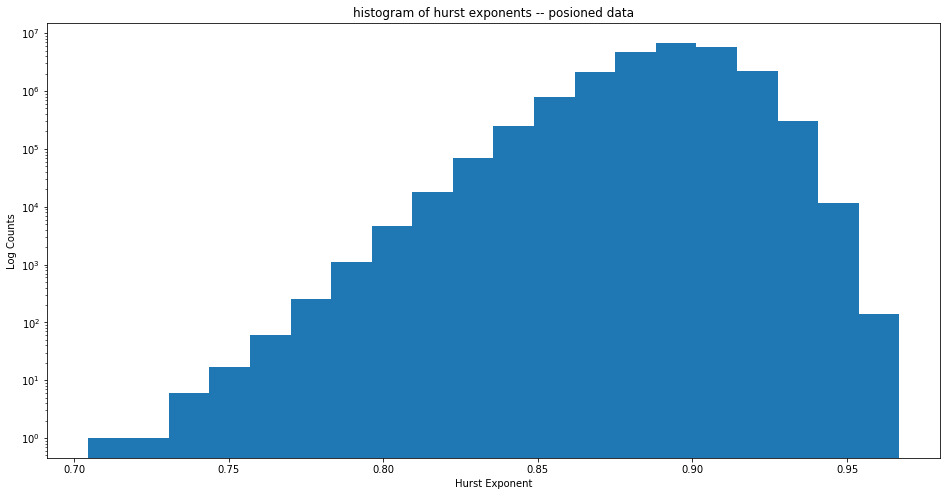

In [9]:
from matplotlib import pyplot as plt 
import numpy as np  

plt.rcParams['figure.figsize'] = [16, 8]

plt.hist(hurst_params.flatten(),log=True,bins=20) 
plt.title("histogram of hurst exponents -- posioned data")
plt.xlabel("Hurst Exponent")
plt.ylabel("Log Counts")
plt.show()

In [13]:
small_hurst_rows, small_hurst_cols= np.where(hurst_params < .80)
print ("Number of items found satisfying condition: {} ".format(small_hurst_rows.shape[0]))
print ("Unique weights with the condition: {} " .format(np.unique(small_hurst_rows).shape[0]))
print ("Unique epochs with the condition: {} " .format(np.unique(small_hurst_cols).shape[0]))

Number of items found satisfying condition: 2159 
Unique weights with the condition: 1916 
Unique epochs with the condition: 41 


In [38]:
weight_variance_mat = []
for i in range(NUM_PARAMS):
    weight_variance_mat.append(np.var(all_params[:,i]))
weight_variance_mat = np.array(weight_variance_mat)
print (weight_variance_mat.shape)

(464154,)


### Interestingly highest and lowest variances in weights are related to last layer parameters!

In [39]:
top_100_max_var = weight_variance_mat.argsort()[-100:][::-1]
low_100_min_var = weight_variance_mat.argsort()[:100]
print ("----Max----")
print (top_100_max_var)
print (np.amax(weight_variance_mat))
print (weight_variance_mat[top_100_max_var[0]])
print ("----Min----")
print (low_100_min_var)
print (np.amin(weight_variance_mat))
print (weight_variance_mat[low_100_min_var[0]])

----Max----
[   440 463444  28461 463495 463447 463478  21466 463492 463503 463467
 463474 463442   5112 463499 463446    432 463380    216 463472 463440
 463489 463455 463450   2768  74849 463487 463486 278453 463497 463445
 463431 463458 463462  65582 204469    360  56289 204473 463443 463473
 463468 463383 463482 204478     56 463451 278420 463435 463488 102685
 278416 463452 463460    458 463423 463466    200 278442 463454 463500
 463414 463493 204435  65563 463419 463501 463459 463436 463483 463481
 204460  16807 204474 204462 102701 463388 463502 463453 463490 463449
 204445 278425 463408  47018 352412 204464  21485    438    439  12118
   7445 130450 204472 102675 463494 102673   7453 463425 278418  84128]
0.59946406
0.59946406
----Min----
[432481 439229 435196 427105 435425 447880 436321 448238 443325 430625
 453793 438461 448892 442557 434365 449320 459688 427304 457121 459745
 450216 439165 460897 462269 435772 436920 457272 435173 435310 450808
 431015 427976 451374 447356 4

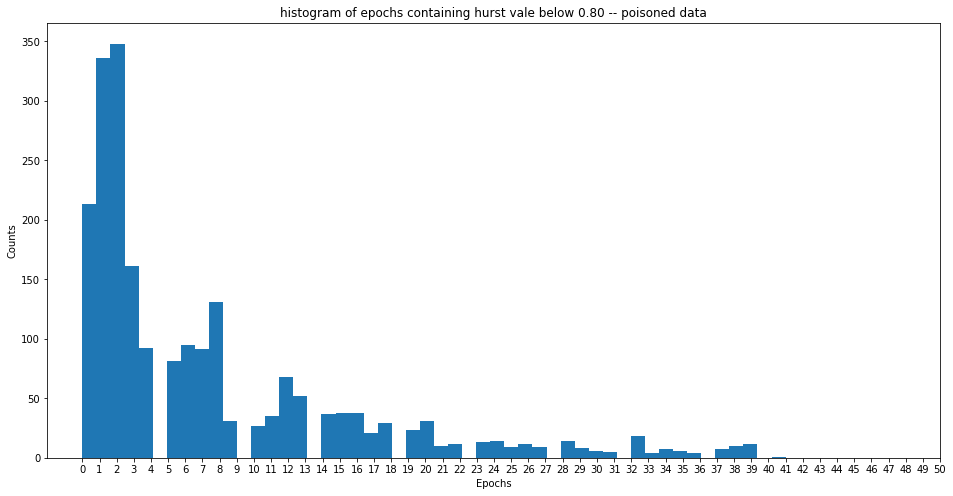

In [14]:
plt.hist(small_hurst_cols.flatten(),bins=50) 
plt.title("histogram of epochs containing hurst vale below 0.80 -- poisoned data")
plt.xlabel("Epochs")
plt.ylabel("Counts")
plt.xticks(np.arange(0, 51, 1.0))
plt.show()

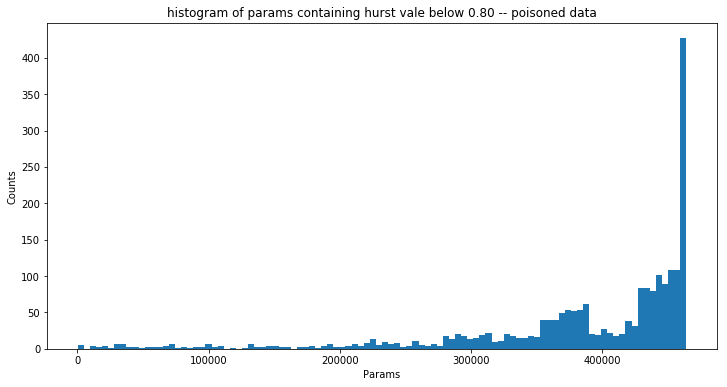

In [43]:
plt.hist(small_hurst_rows.flatten(),bins=100) 
plt.title("histogram of params containing hurst vale below 0.80 -- poisoned data")
plt.xlabel("Params")
plt.ylabel("Counts")
plt.show()

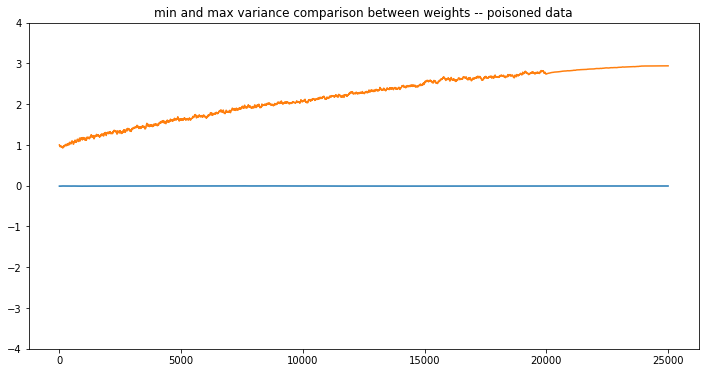

0.8866417
0.8799493


In [44]:
axes = plt.gca()
plt.plot(all_params[:,(432481,463474)]) 
plt.title("min and max variance comparison between weights -- poisoned data")
#plt.xlabel("Hurst Exponent")
#plt.ylabel("Log Counts")
axes.set_ylim([-4.0,4.0])
#plt.legend()
plt.show()
print (np.mean(hurst_params[432481:]))
print (np.mean(hurst_params[463474:]))